### **Problem with ImbalanceDatasets** :
- Imbalanced datasets occur when classes are not represented equally, with one class significantly outnumbering others. 
- This imbalance can lead models to become biased, predicting the `majority class more often and neglecting the minority class`.
- Techniques like resampling (e.g., `SMOTE`) to improve model performance and fairness.

## **Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

## **Loading the Dataset**

In [413]:
df = pd.read_csv('data/customer_churn.csv')

df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Exploratory Data Analysis - (Note: Only on Target Column)

In [7]:
df.shape

(7043, 21)

In [415]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: 0 if x == ' ' else float(x))

In [417]:
print(df['TotalCharges'].dtype)

float64


In [74]:
df['Churn'].value_counts(normalize= True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

* Clearly shows that there is `high imbalance` in dataset.

<Axes: xlabel='Churn', ylabel='count'>

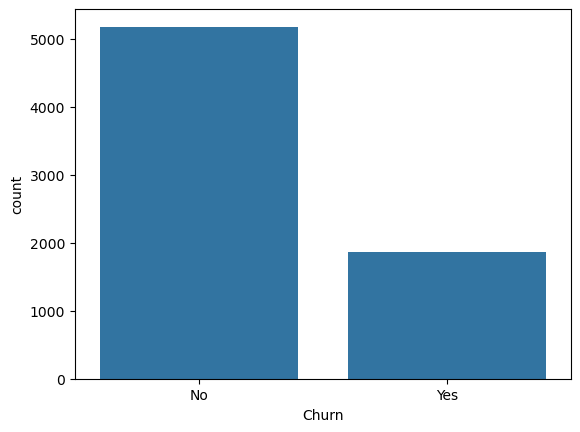

In [77]:
sns.countplot(data = df, x = 'Churn')

In [419]:
df = df.drop(columns = ['customerID'])

In [421]:
X = df.drop(columns = ['Churn'])
y = df[['Churn']]

In [425]:
numeric_df = X.select_dtypes(include = 'number')
categorical_df = X.select_dtypes(exclude='number')

## Data Preparation

In [427]:
# Rescaling Numerical Features

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

numeric_df_transformed = pd.DataFrame(standard_scaler.fit_transform(numeric_df), 
                                      columns = standard_scaler.get_feature_names_out(),
                                      index = numeric_df.index)

In [429]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

categorical_df_transformed = pd.DataFrame(ohe.fit_transform(categorical_df.iloc[:, :-1]).toarray(),
                                          columns=ohe.get_feature_names_out(),
                                          index = categorical_df.iloc[:, :-1].index)

In [431]:
X = pd.concat([numeric_df_transformed, categorical_df_transformed], axis = 1)

In [433]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for column in y.columns:
    y[column] = le.fit_transform(y[column])

C:\Users\VARSHINA\AppData\Local\Temp\ipykernel_16796\1842719179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column] = le.fit_transform(y[column])


In [435]:
df = pd.concat([X, y], axis = 1)

In [437]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Building

In [439]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1086
           1       0.54      0.63      0.58       323

    accuracy                           0.79      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.80      0.79      0.80      1409



* Clearly shows f1score for class1 is low compared to class0.

### Method 1: Undersampling


In [441]:
count_class_0, count_class_1 = df.Churn.value_counts()

df_class_0 = df[df['Churn'] == 0]
df_class_1 = df[df['Churn'] == 1]

In [443]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


In [445]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [447]:
y_train.value_counts()

Churn
0    1495
1    1495
Name: count, dtype: int64

### **Logistic Regression** 


In [449]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       352
           1       0.76      0.72      0.74       396

    accuracy                           0.73       748
   macro avg       0.73      0.73      0.73       748
weighted avg       0.73      0.73      0.73       748



* F1-score for minority class 1 improved from `0.58 to 0.74`. Score for class 0 reduced to `0.72 from 0.86`.

### Method 2: Oversampling

In [452]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
Churn
0    5174
1    5174
Name: count, dtype: int64


In [454]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [459]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       971
           1       0.78      0.74      0.76      1099

    accuracy                           0.75      2070
   macro avg       0.75      0.75      0.75      2070
weighted avg       0.75      0.75      0.75      2070



* F1-score for minority class 1 improved from `0.58 to 0.76`. Score for class 0 reduced to `0.74 from 0.86`.

### Method 3 : SMOTE

In [497]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

In [489]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state= 42)
X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

Churn
0    5174
1    5174
Name: count, dtype: int64

In [493]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [495]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       938
           1       0.82      0.75      0.78      1132

    accuracy                           0.77      2070
   macro avg       0.77      0.78      0.77      2070
weighted avg       0.78      0.77      0.77      2070



* F1-score for minority class 1 improved from `0.58 to 0.78`. Score for class 0 reduced to `0.76 from 0.86`.

### Method 4: Use of Ensemble with undersampling

In [523]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

In [525]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [527]:
y_train.value_counts()

Churn
0    4139
1    1495
Name: count, dtype: int64

In [531]:
df1 = X_train.copy()
df1['Churn'] = y_train

In [534]:
df1_class0 = df1[df1.Churn==0]
df1_class1 = df1[df1.Churn==1]

In [536]:
def get_train(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train 

In [540]:
X_train, y_train = get_train(df1_class0, df1_class1, 0, 1495)

classifier.fit(X_train, y_train)

pred1 = classifier.predict(X_test)

print(classification_report(pred1, y_test))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       834
           1       0.76      0.50      0.60       575

    accuracy                           0.73      1409
   macro avg       0.74      0.70      0.70      1409
weighted avg       0.74      0.73      0.72      1409



In [544]:
X_train, y_train = get_train(df1_class0, df1_class1, 1495, 2990)

classifier.fit(X_train, y_train)

pred2 = classifier.predict(X_test)

print(classification_report(pred2, y_test))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       825
           1       0.78      0.50      0.61       584

    accuracy                           0.73      1409
   macro avg       0.75      0.70      0.70      1409
weighted avg       0.74      0.73      0.72      1409



In [546]:
X_train, y_train = get_train(df1_class0, df1_class1, 2990, 4130)

classifier.fit(X_train, y_train)

pred3 = classifier.predict(X_test)

print(classification_report(pred3, y_test))

              precision    recall  f1-score   support

           0       0.65      0.90      0.76       750
           1       0.80      0.46      0.58       659

    accuracy                           0.69      1409
   macro avg       0.73      0.68      0.67      1409
weighted avg       0.72      0.69      0.68      1409



In [550]:
pred_final = pred1.copy()
for i in range(len(pred1)):
    n_ones = pred1[i] + pred2[i] + pred3[i]
    if n_ones>1:
        pred_final[i] = 1
    else:
        pred_final[i] = 0

In [554]:
cl_rep = classification_report(y_test, pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.74      1409



* f1-score for minority class 1 improved to `0.60 from 0.58`. The score for majority class 0 is suffering and reduced to `0.79 from 0.86` 